# Twitter Analyser
David Norrish, November 2017

Call Twitter API to retrieve tweets for a user-defined search query, then performs network and sentiment analysis.

## 1. Retrieve tweets
The first step is to call the Twitter tweet search API to retrieve tweets, which we will save in JSON format in a .BZ2 file to save disk space.  
The TwitterAPI has a rich search functionality, with available operators described [here](https://developer.twitter.com/en/docs/tweets/search/guides/standard-operators).

In this example we will specify the search query, language, count of tweets to return, search by recent tweets (as opposed to popular), and define an output file.

In [1]:
# Retrieve tweets and save to an external .bz2 file
from twitter_search import search_tweets

already_have_tweets = True

if already_have_tweets:
    filename = 'loveIsLove.txt.bz2'
    print('Attempting to use tweets from file ./tweets/' + filename)
else:
    search_query = 'when'
    language = 'en'
    count = 300    # the rate limit is 100 tweets per API call, so this will make 3 calls
    result_type = 'mix'
    filename = 'when.txt.bz2'

    args = {
        'count': count,
        'lang': language,
        'result_type': result_type,
        'file': filename
        }

    search_tweets(search_query, **args)

Attempting to use tweets from file ./tweets/loveIsLove.txt.bz2


## 2. Check data
Check that the API call and data saving worked correctly, browse a few tweets and check for retweet status.  
Note that tweets are saved in JSON, so we can parse them as dictionaries.

In [2]:
import bz2
import json, re
import networkx as nx

# Import and inspect a BZ2 document of tweets in JSON format
print(filename)
if not re.search('\.txt\.bz2$', filename):    # added on by script file
    filename = filename + '.txt.bz2'
path = './tweets/' + filename

tweet_file = bz2.BZ2File(path, mode='r')
for i in range(1, 7):
    tweet = json.loads(tweet_file.readline())
    print(str(i) + '. ' + tweet['text'])

loveIsLove.txt.bz2
1. RT @mhall55nine: Into The Misty Dawn! #screenprint  #LoveIsLove #ArtTherapy #futurenow https://t.co/pOZxnSxObW
2. Hello 😀 beautiful art🏳️‍🌈😍 #Shadowhunters #ShadowhuntersSeason3 #malec #aleclightwood #MagnusBane #LoveIsLove https://t.co/fbZoVyxet2
3. Check out this week’s powerful guest post by @treypearson #MondayBlogs #loveislove #FaithfullyLGBT https://t.co/K3zgu5g0CJ
4. We are thrilled to hear early responses to the Where @WhereTrueLoveIs devotional. May God's healing love shine thro… https://t.co/pwc0vU0tTl
5. Omgosh @samsmithworld "HIM" ❤️❤️❤️ #LoveIsLove
6. Please make this happen! x ❤ #No2LGBTHate #LoveIsLove https://t.co/mqMjxFEVGE


When we build the network graph in the next step we'll use retweet status to connect nodes. Let's get a feel for that.

In [ ]:
tweet_file.seek(0)    # Return to top of the file

for i in range(8):
    # Extract user id and optional retweeted user id
    tweet = json.loads(tweet_file.readline())
    user_id = tweet['user']['id']
    #if isinstance(user_id, dict):    # sometimes this is returned as a dictionary
    #    user_id = user_id.values()[0]
    user_id = int(user_id)
    print(str(i) + '. User id: {}, '.format(user_id), end = '')
    
    if 'retweeted_status' in tweet:
        retweeted_user_id = tweet['retweeted_status']['user']['id']
        #if isinstance(retweeted_user_id, dict):
        #    retweeted_user_id = retweeted_user_id.values()[0]
        retweeted_user_id = int(retweeted_user_id)
        print('retweeted from: {}'.format(retweeted_user_id))
    else:
        print('original tweet')

Depending on your search term, there is often a rich mix of original and re-tweets.  
Let's see if there are any major players being retweeted.

In [4]:
tweet_file.seek(0)    # Return to top of the file

retweetees = {}

for line in tweet_file:
    tweet = json.loads(tweet_file.readline())
    if 'retweeted_status' in tweet:
        retweeted_user_id = tweet['retweeted_status']['user']['id']
        if retweeted_user_id not in retweetees:
            retweetees[retweeted_user_id] = 1
        else:
            retweetees[retweeted_user_id] += 1

top_retweetees = sorted(retweetees.items(), reverse=True, key=lambda x: x[1])
for i in range(8):
    print('ID {}, retweeted {} times'.format(top_retweetees[i][0], top_retweetees[i][1]))

ID 23497233, retweeted 616 times
ID 27725199, retweeted 171 times
ID 2920033789, retweeted 158 times
ID 19397942, retweeted 80 times
ID 21089219, retweeted 75 times
ID 24180861, retweeted 70 times
ID 14700117, retweeted 70 times
ID 2203993285, retweeted 64 times


We can investigate rates of "favoriting" and retweeting of original tweets.

In [5]:
import numpy as np
tweet_file.seek(0)

IDs = set()
retweets = []
favorites = []

for line in tweet_file:
    tweet = json.loads(tweet_file.readline())
    # Retween count is shared between all retweets of the original, but favorites count is by instance. Use original tweet
    if 'retweeted_status' in tweet:
        if not tweet['retweeted_status']['id'] in IDs:
            retweets.append(tweet['retweeted_status']['retweet_count'])
            favorites.append(tweet['retweeted_status']['favorite_count'])
            IDs.add(tweet['retweeted_status']['id'])
    else:
        if not tweet['id'] in IDs:
            retweets.append(tweet['retweet_count'])
            favorites.append(tweet['favorite_count'])
            IDs.add(tweet['id'])

favorites_per_retweet = np.sum(favorites) / np.sum(retweets)

print('Unique tweets: {}'.format(len(IDs)))
print('Median favorites per tweet: {:.0f}'.format(np.median(favorites)))
print('Mean favorites per tweet: {:.1f}'.format(np.mean(favorites)))
print('\nMedian retweets per tweet: {:.0f}'.format(np.median(retweets)))
print('Mean retweets per tweet: {:.1f}'.format(np.mean(retweets)))
print('\nAverage favorites/retweet: {}'.format(favorites_per_retweet))

Unique tweets: 2259
Median favorites per tweet: 1
Mean favorites per tweet: 138.3

Median retweets per tweet: 0
Mean retweets per tweet: 57.0

Average favorites/retweet: 2.4257698730146404


Tweets generally have a very skewed distribution, with most receiving almost no attention, and a small number receiving a huge amount of attention. Ratio of favorites to retweets is often around 2.3 - 2.4. We can use this to derive a "score" per tweet by weighting retweets and likes by their rarity, and consequently print the most "popular" tweets

In [6]:
scores = [favorites[i] + retweets[i] * favorites_per_retweet for i in range(len(favorites))]

print('Median score per tweet: {:.1f}'.format(np.median(scores)))
print('Mean score per tweet: {:.1f} \n'.format(np.mean(scores)))

scores = sorted(scores, reverse=True)
# print(scores)
threshold = scores[5]

# Extract most popular tweets
tweet_file.seek(0)
top_tweets= []
IDs = set()

for line in tweet_file:
    tweet = json.loads(tweet_file.readline())
    if 'retweeted_status' in tweet:
        score = tweet['retweeted_status']['retweet_count'] * favorites_per_retweet + tweet['retweeted_status']['favorite_count']
        ID = tweet['retweeted_status']['id']
    else:
        score = tweet['retweet_count'] * favorites_per_retweet + tweet['favorite_count']
        ID = tweet['id']

    if score > threshold and not ID in IDs:
        top_tweets.append((tweet['text'], score, ID))
        IDs.add(ID)

top_tweets = sorted(top_tweets, key=lambda x: x[1], reverse=True)
        
for tweet in top_tweets:
    print('Score ({:.1f}), ID: {} \n{} \n'.format(tweet[1], tweet[2], tweet[0]))

Median score per tweet: 2.0
Mean score per tweet: 276.5 

Score (238332.3), ID: 742135690599665665 
RT @danielhowell: #LoveIsLove shows how amazing the internet can be to spread love and support instead of hate. you are beautiful love your… 

Score (99134.3), ID: 752201488240242689 
RT @GIRLSKISSGlRLS: in memory of the orlando victims- a reminder that love will always win in the end ♡ #loveislove #lovewins
https://t.co/… 

Score (51609.9), ID: 930578000659210240 
RT @Sia: the Australian people have spoken loud and clear. #LoveIsLove 🏳️‍🌈🏳️‍🌈🏳️‍🌈 https://t.co/FMQ1tDc9yY 

Score (26349.8), ID: 742141708142399488 
RT @MichaelFaudet: Always be the voice for love, tolerance and kindness. #LoveIsLove https://t.co/a13ZRRjAdl 

Score (24209.8), ID: 909126130359291905 
RT @itzzkait: This is such a powerful message #loveislove https://t.co/fDcgBmrO4M 



## 3. Building Graphs
We will use the excellent networkx package to build a graph, by placing a directed edge from each retweeting user to the user they retweeted. Note that building the graph may take some time depending on how how many tweets are in your dataset.

In [7]:
import networkx as nx
tweet_file.seek(0)

#  Initialise the networkx graph
retweet_graph = nx.DiGraph()

# Go line by line (i.e. tweet by tweet), building graph
for line in tweet_file:
    tweet = json.loads(line)
    
    # Only include tweets that are retweets
    if 'retweeted_status' in tweet:
        # Determine user id
        user_id = tweet['user']['id']
        # if isinstance(user_id, dict):
        #     user_id = user_id.values()[0]
        user_id = int(user_id)
    
        # Determine the retweeted user id
        retweeted_user_id = tweet['retweeted_status']['user']['id']
        # if isinstance(retweeted_user_id, dict):
        #     retweeted_user_id = retweeted_user_id.values()[0]
        # retweeted_user_id = int(retweeted_user_id)
        
        # Add the two nodes in the graph, if not already there
        if user_id not in retweet_graph:
            retweet_graph.add_node(user_id)
        if retweeted_user_id not in retweet_graph:
            retweet_graph.add_node(retweeted_user_id)
        retweet_graph.add_edge(user_id, retweeted_user_id)

Check the dimensionality of the graph. Twitter graphs are generally very sparse.

In [14]:
nodes = retweet_graph.number_of_nodes()
edges = retweet_graph.number_of_edges()
print('Number of nodes: {}'.format(nodes))
print('Number of edges: {}'.format(edges))
max_edges = int(nodes * (nodes - 1))
print('\nGiven that the maximum number of edges in a directed graph is {} (N * (N - 1)),\nthis graph is {:.1%} connected'.format(max_edges, edges / max_edges))

Number of nodes: 7218
Number of edges: 6630

Given that the maximum number of edges in a directed graph is 52092306 (N * (N - 1)),
this graph is 0.0% connected


In [20]:
# create an undirected version of our graph
G = retweet_graph.to_undirected()

# check if graph is connected
if nx.is_connected(G):
    print('The graph is connected, it has only one connected component')
else:
    print('The graph contains {} connected components.'.format(nx.number_connected_components(G)))
    
GCCs = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
print('Connected components, inversely sorted by size:')
for i in range(5):
    print('Rank {:d}: {:d} users ({:.3f}% of total population)'.format(i, len(GCCs[i]), (float(len(GCCs[i])) * 100 / len(G))))

Gcc = GCCs[0]

The graph contains 803 connected components.
Connected components, inversely sorted by size:
Rank 0: 4116 users (57.024% of total population)
Rank 1: 136 users (1.884% of total population)
Rank 2: 102 users (1.413% of total population)
Rank 3: 59 users (0.817% of total population)
Rank 4: 51 users (0.707% of total population)


We can investigate traits of the graph, including:
- radius (the smallest number of steps that allows all nodes to be reached from at least one node in the graph)
- diameter (the greatest number of steps that allows all nodes to be reached from at least one node in the graph)

In [21]:
print('Giant connected component contains {} nodes'.format(len(Gcc)))
print('Giant connected component contains {} edges'.format(Gcc.number_of_edges()))
print('Radius of the giant connected component is ' + str(nx.radius(Gcc)))
print('Diameter of the giant connected component is ' + str(nx.diameter(Gcc)))

Giant connected component contains 4116 nodes
Giant connected component contains 4260 edges
Radius of the giant connected component is 11
Diameter of the giant connected component is 22


Restrict graph based on in-degree/outdegree

In [45]:
print(type(retweet_graph))
print(type(Gcc))

<class 'networkx.classes.digraph.DiGraph'>
<class 'networkx.classes.graph.Graph'>


In [46]:
indegrees = []
outdegrees = []
for node in retweet_graph:
    indegrees.append(retweet_graph.in_degree(node))
    outdegrees.append(retweet_graph.out_degree(node))

print(len(indegrees))
print(max(indegrees))
print(np.median(indegrees))
print(len(indegrees)/len(retweet_graph))
print(max(outdegrees))

7218
1204
0.0
1.0
11


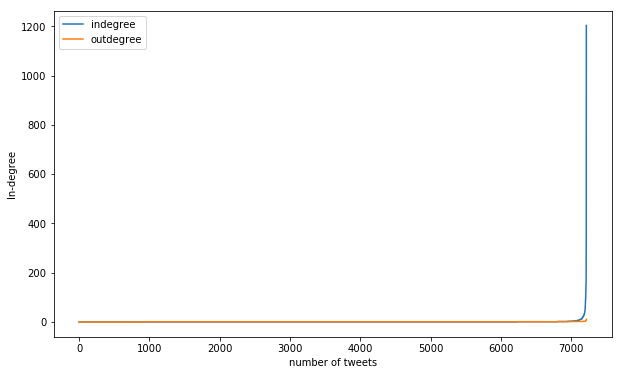

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(sorted(indegrees))
plt.plot(sorted(outdegrees))
plt.ylabel('In-degree')
plt.xlabel('number of tweets')
plt.legend(['indegree', 'outdegree'], loc='upper left')
plt.show()

If we throw away the huge number of nodes with 0 or minimal in-degree, we can reduce the graph size substantially and make it tractable to analyse further

In [54]:
zeroes = [x for x in indegrees if x == 0]
two_pluses = [x for x in indegrees if x > 0]
print(len(zeroes))
print(len(two_pluses))

6229
989


In [56]:
to_delete = []
for node in retweet_graph:
    if retweet_graph.in_degree(node) < 1:
        to_delete.append(node)

pruned_graph = retweet_graph.copy()
print(len(pruned_graph))
for node in to_delete:
    pruned_graph.remove_node(node)
print(len(pruned_graph))

7218
989


Find the most central nodes

In [22]:
nodes_bc = nx.betweenness_centrality(retweet_graph)
max_node_bc = 0
max_nodes = []
for node, score in nodes_bc.iteritems():
    if score > max_node_bc:
        max_nodes = [node]
        max_node_bc = score
    elif score == max_node_bc:
        max_nodes.append(node)
print('The node(s) with highest betweenness centrality are {}, with a value of {}'.format(max_nodes, max_node_bc))

KeyboardInterrupt: 

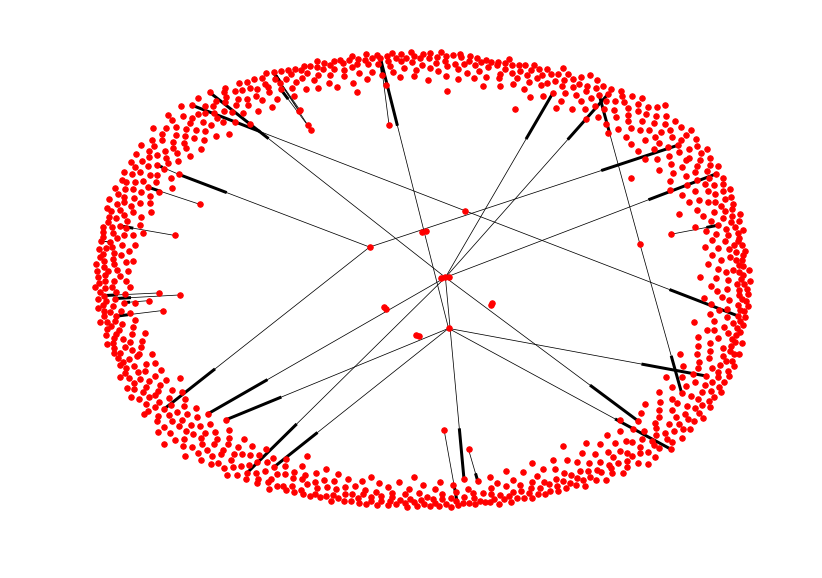

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

# Determine the spring layout
pos = nx.spring_layout(pruned_graph)

# draw the graph
plt.figure(figsize=(14,10))
plt.axis('off')
nx.draw_networkx_nodes(pruned_graph, pos, node_size=30)
nx.draw_networkx_edges(pruned_graph, pos, width=0.75, arrows=True)

### Reply graph
We can also construct the reply graph. First check what replies look like

In [ ]:
# Get an example tweet which replies to a user in order to see the structure
tweet_file.seek(0)

# Read through tweets until find an example, see what it looks like
example_found = False
i = 0
while not example_found:
    tweet = json.loads(tweet_file.readline())
    if 'in_reply_to_user_id' in tweet and tweet['in_reply_to_user_id'] != None:
        example_found = True
    i += 1

print(str(i) + '. User ID: ' + str(tweet['user']['id']) + ', in reply to ' + str(tweet['in_reply_to_user_id']))

And how many replies we expect:

In [ ]:
tweet_file.seek(0)
reply_graph = nx.DiGraph()

## code for constructing the Directed Graph `DG`
# Parse the JSON tweet object and extract information:
# user/id
# go line by line (ergo, tweet by tweet), building graph
for line in tweet_file:
    # load the JSON object from the read line
    tweet = json.loads(line)
    
    # If the current tweet is a reply
    if tweet['in_reply_to_user_id'] != None:
        user_id = tweet['user']['id']
        # if isinstance(user_id, dict):
        #     user_id = user_id.values()[0]
        # user_id = int(user_id)
    
        # Determine the replied to user id
        in_reply_to_user_id = tweet['in_reply_to_user_id']
        # if isinstance(in_reply_to_user_id, dict):
        #     in_reply_user_id = in_reply_user_id.values()[0]
        # in_reply_user_id = int(in_reply_user_id)
       
        # Add the two nodes in the graph, if not already there
        if user_id not in reply_graph:
            reply_graph.add_node(user_id)
        if in_reply_to_user_id not in reply_graph:
            reply_graph.add_node(in_reply_to_user_id)
        reply_graph.add_edge(user_id, in_reply_to_user_id)

In [ ]:
# Determine the spring layout
pos = nx.spring_layout(reply_graph)

# draw the graph
plt.figure(figsize=(14,10))
plt.axis('off')
nx.draw_networkx_nodes(reply_graph, pos, node_size=50)
nx.draw_networkx_edges(reply_graph, pos, width=0.75, arrows=True)